In [1]:
import os
import sys
import time
import csv
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import assay
import util
import calibrate as cal

from sklearn.linear_model import Ridge
    
import numpy as np
import scipy as sc
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 16

import seaborn as sns
sns.set_style('darkgrid')

In [21]:
def get_similarity(X_p, Xtrain_nxp):
    tmp = np.sum(Xtrain_nxp[:, 1 : 14] == X_p[1 : 14][None, :], axis=1)
    return np.mean(tmp)

In [2]:
fitness_str = 'blue'
n_trains = [92, 192, 384]
lmbdas = [0, 2, 4, 6]
n_seed = 1000
measurement_noise = False
# TODO: suitable plot for quantifying covariate extrapolation?

reg = 10
order = 2
data = assay.PoelwijkData(fitness_str, order=order)
model = Ridge(alpha=reg, fit_intercept=True)

fitness_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
dist_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
win_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
t0 = time.time()
for t, n_train in enumerate(n_trains):

    for seed in range(n_seed):

        # get random training data
        np.random.seed(seed)
        train_idx = np.random.choice(data.n, n_train, replace=True)
        Xtrain_nxp, ytrain_n = data.X_nxp[train_idx], data.y_n[train_idx]
        if measurement_noise:
            ytrain_n = data.get_measurements(train_idx)

        # train model
        model.fit(Xtrain_nxp[:, 1 :], ytrain_n)

        for l, lmbda in enumerate(lmbdas):

            # construct test covariate distribution
            predall_n = model.predict(data.X_nxp[:, 1 :])
            punnorm_n = np.exp(lmbda * predall_n)
            Z = np.sum(punnorm_n)
            p_n = punnorm_n / Z

            # draw sample
            test_idx = np.random.choice(data.n, p=p_n, size=1)
            fitness_txlxs[t, l, seed] = data.y_n[test_idx]
            if measurement_noise:
                fitness_txlxs[t, l, seed] = data.get_measurements(test_idx)
                
            if fitness_txlxs[t, l, seed] >= np.max(ytrain_n):
                win_txlxs[t, l, seed] = 1
    print('done with {}. {} s'.format(n_train, time.time() - t0))

92 features
Loading estimated noise SE precomputed with order 7 and significance level 0.01
done with 92. 18.529264450073242 s
done with 192. 37.93812298774719 s
done with 384. 57.04491424560547 s


In [60]:
for t in range(len(n_trains)):
    for l in range(len(lmbdas)):
        print(n_trains[t], lmbdas[l], np.mean(win_txlxs[t, l]))

92 0 0.007
92 2 0.026
92 4 0.06
92 6 0.089
192 0 0.003
192 2 0.019
192 4 0.039
192 6 0.064
384 0 0.002
384 2 0.009
384 4 0.019
384 6 0.032


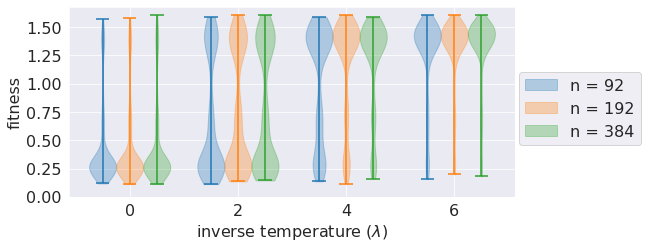

In [9]:
import matplotlib.patches as mpatches
lw = 4
alpha = 0.7
vextremew = 0.3
weight_ylim = [-10, 400]
arrl = np.array(lmbdas)
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(8, 3.5));
offsets = [-0.5, 0, 0.5]

labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

for t in range(len(n_trains)):
    ls = [l + offsets[t] for l in lmbdas]

    v = plt.violinplot(fitness_txlxs[t].T, ls, widths=0.5, points=200, showextrema=True)
    add_label(v, "n = {}".format(n_trains[t]))
    for pc in v['bodies']:
        pc.set_color(colors[t])
    
plt.xlabel('inverse temperature ($\lambda$)');
plt.xticks(lmbdas)
plt.ylabel('fitness');
plt.yticks([0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50]);
plt.legend(*zip(*labels), bbox_to_anchor=(1.3, 0.7));

In [53]:
fitness_str = 'red'
n_trains = [96, 192, 384]
lmbdas = [0, 2, 4, 6]
n_seed = 5000
alpha = 0.1
y_interval = 0.01
score_str = "loo"
ntrain2reg = {24:10, 48:10, 96:10, 192:1, 384: 1}

cscov_txl = np.zeros([len(n_trains), len(lmbdas)])
cicov_txl = np.zeros([len(n_trains), len(lmbdas)])
cslen_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
cilen_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
sets_txl = [len(lmbdas) * [None] for _ in range(len(n_trains))]  # NO: len(n_trains) * [len(lmbdas) * [None]]
y_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
pred_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])

for t, n_train in enumerate(n_trains):
    reg = ntrain2reg[n_train]
    for l, lmbda in enumerate(lmbdas):
        
        fname = '../results/113021/{}_n{}_lambda{}_alpha{}_gamma{}.npz'.format(
            fitness_str, n_train, lmbda, alpha, reg)
        d = np.load(fname, allow_pickle=True)
        
        csset_s = d['cs{}set_s'.format(score_str)]  # array of s (variable-length) arrays
        ciset_s = d['ci{}set_s'.format(score_str)]
        sets_txl[t][l] = ciset_s
        
        cslen_txlxs[t, l] = [cs.size * y_interval for cs in csset_s]
        cilen_txlxs[t, l] = [cs.size * y_interval for cs in ciset_s]
        
        y_txlxs[t, l] = d['ytest_s']
        pred_txlxs[t, l] = d['predtest_s']
        
        cscov_txl[t, l] = np.mean(d['cs{}cov_s'.format(score_str)])
        cicov_txl[t, l] = np.mean(d['ci{}cov_s'.format(score_str)])
    

14 features
Loading estimated noise SE precomputed with order 7 and significance level 0.01


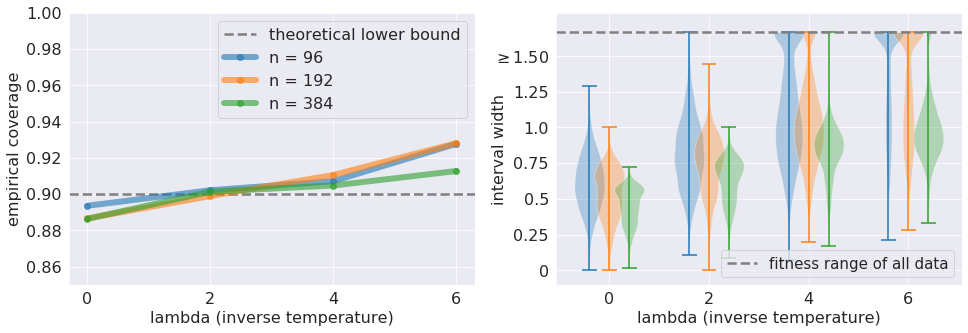

In [35]:
# blue
alpha = 0.1
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
offsets = [-1, 0, 1]
data = assay.PoelwijkData(fitness_str, order=1)
arrl = np.array(lmbdas)

ax[0].axhline(1 - alpha, linestyle="--", linewidth=2.5, color='gray', label='theoretical lower bound')
for t, cov_l in enumerate(cicov_txl):
    ax[0].plot(lmbdas, cov_l, '-o', linewidth=6, alpha=0.6, label="n = {}".format(n_trains[t]))
ax[0].set_xlabel('lambda (inverse temperature)');
ax[0].set_xticks(lmbdas)
ax[0].set_ylabel('empirical coverage'); plt.ylim([0.84, 1.01]);
ax[0].legend();
ax[0].set_ylim([0.85, 1]);

fit_range = np.max(data.y_n) - np.min(data.y_n)
ax[1].axhline(fit_range, linestyle='--', color='gray', linewidth=2.5, label='fitness range of all data');
for l, len_lxs in enumerate(cilen_txlxs):
    len_lxs = np.fmin(len_lxs, fit_range)
    ax[1].violinplot(len_lxs.T, arrl + offsets[l] * 0.4, points=1000, widths=0.6, showextrema=True)
ax[1].set_ylabel('interval width')
ax[1].yaxis.set_label_coords(-0.12, 0.5)
ax[1].legend(loc='lower right', fontsize=15);
ax[1].set_xlabel('lambda (inverse temperature)');
ax[1].set_ylim([-0.1, 1.6]);

ax[1].set_yticks([0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50]);
ax[1].set_yticklabels([0, 0.25, 0.50, 0.75, 1.00, 1.25, '$\geq$1.50']);

14 features
Loading estimated noise SE precomputed with order 7 and significance level 0.01


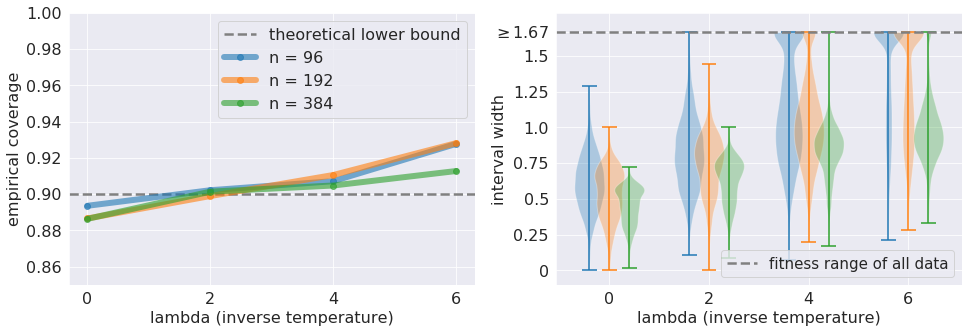

In [38]:
# red
alpha = 0.1
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
offsets = [-1, 0, 1]
data = assay.PoelwijkData(fitness_str, order=1)
arrl = np.array(lmbdas)

ax[0].axhline(1 - alpha, linestyle="--", linewidth=2.5, color='gray', label='theoretical lower bound')
for t, cov_l in enumerate(cicov_txl):
    ax[0].plot(lmbdas, cov_l, '-o', linewidth=6, alpha=0.6, label="n = {}".format(n_trains[t]))
ax[0].set_xlabel('lambda (inverse temperature)');
ax[0].set_xticks(lmbdas)
ax[0].set_ylabel('empirical coverage'); plt.ylim([0.84, 1.01]);
ax[0].legend();
ax[0].set_ylim([0.85, 1]);

fit_range = np.max(data.y_n) - np.min(data.y_n)
ax[1].axhline(fit_range, linestyle='--', color='gray', linewidth=2.5, label='fitness range of all data');
for l, len_lxs in enumerate(cilen_txlxs):
    len_lxs = np.fmin(len_lxs, fit_range)
    ax[1].violinplot(len_lxs.T, arrl + offsets[l] * 0.4, points=1000, widths=0.6, showextrema=True)
ax[1].set_ylabel('interval width')
ax[1].yaxis.set_label_coords(-0.12, 0.5)
ax[1].legend(loc='lower right', fontsize=15);
ax[1].set_xlabel('lambda (inverse temperature)');
ax[1].set_ylim([-0.1, 1.8]);

ax[1].set_yticks([0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.67]);
ax[1].set_yticklabels([0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, '$\geq$1.67']);

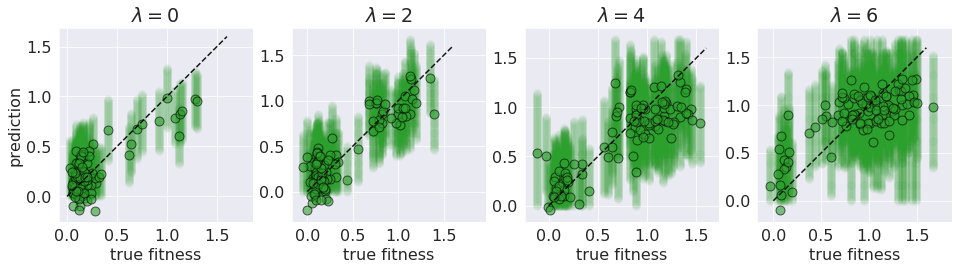

In [54]:
plt.figure(figsize=(16, 5));
t = 2
lmbda_idx = [0, 1, 2, 3]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
seeds = range(100)
alpha = 0.05

for l in lmbda_idx:
    plt.subplot(1, len(lmbda_idx), l + 1)

    for seed in seeds:
        ciset = sets_txl[t][l][seed]
        plt.scatter(y_txlxs[t, l, seed] * np.ones([ciset.size]), ciset, color=colors[t], alpha=alpha, s=60)

    plt.scatter(y_txlxs[t, l, seeds], pred_txlxs[t, l, seeds], color=colors[t],
                alpha=0.6, s=80, edgecolors='k');

    util.plot_xy([0, 1.6], [0, 1.6], color='k');
    plt.axis('square');
    if l == 0:
        plt.yticks(np.arange(0, 1.6, 0.5));
        plt.ylabel('prediction')
        
    plt.title('$\lambda = {}$'.format(lmbdas[l]));
    plt.xlabel('true fitness');
    plt.xticks(np.arange(0, 1.6, 0.5));

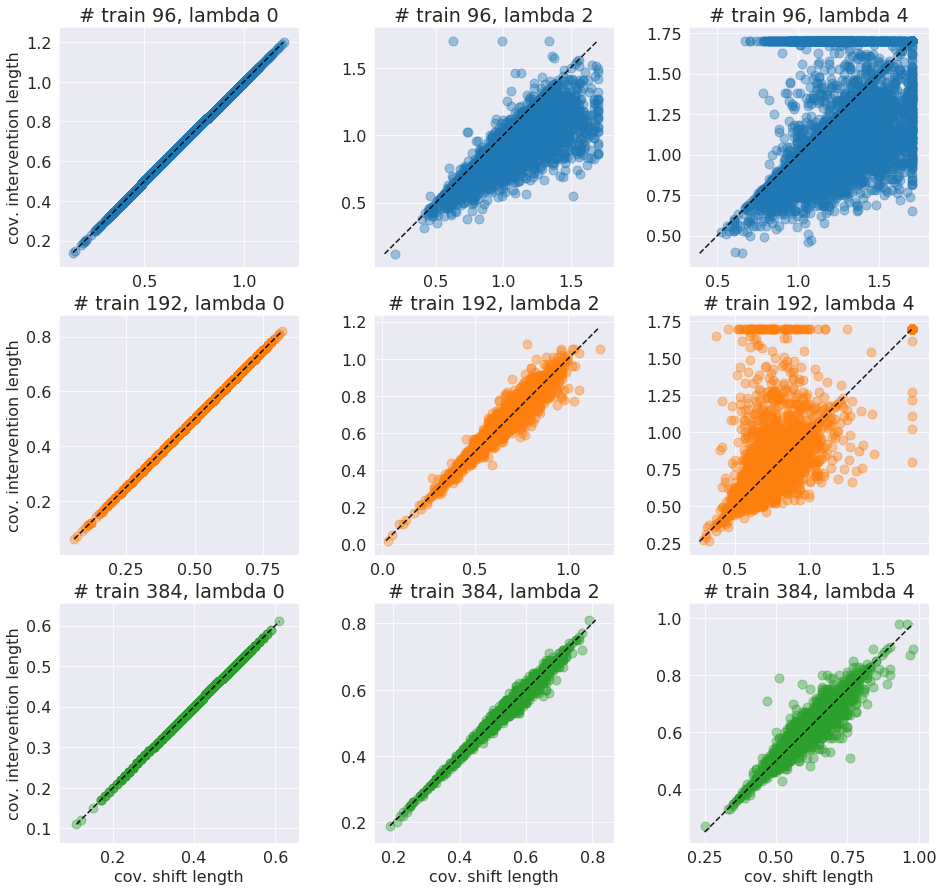

In [9]:
plt.figure(figsize=(16, 15));
# lmbdas = [0, 2, 4, 6]
ntrain_is = [0, 1, 2]
lmbda_js = [0, 1, 2]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
alpha = 0.4

for i, ntrain_i in enumerate(ntrain_is):
    for j, lmbda_j in enumerate(lmbda_js):
        
        plt.subplot(len(ntrain_is), len(lmbda_js), i * (len(lmbda_js)) + j + 1)
        plt.scatter(cslen_txlxs[ntrain_i, lmbda_j], cilen_txlxs[ntrain_i, lmbda_j], color=colors[i],
                    alpha=alpha, s=80);
        
        util.plot_xy(cslen_txlxs[ntrain_i, lmbda_j], cilen_txlxs[ntrain_i, lmbda_j], color='k');
        plt.axis('square');
        # plt.xticks(np.arange(0, 1.6, 0.5));
        plt.title('# train {}, lambda {}'.format(n_trains[ntrain_i], lmbdas[lmbda_j]));
        if i == len(ntrain_is) - 1:
            plt.xlabel('cov. shift length');
        if j == 0:
            plt.ylabel('cov. intervention length')